(512, 512, 4)
[  0 128 255]


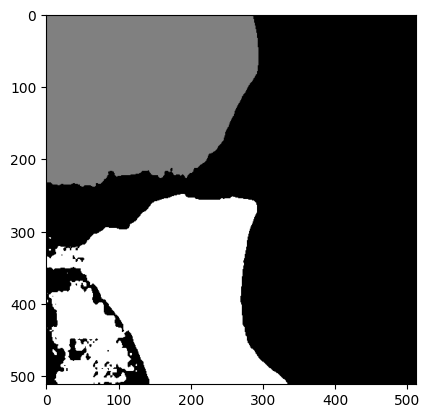

In [14]:
path = '/mnt/iMVR/zhengf/Medical-SAM2/vis/seg1/fedavg/video4/27/pred_mask_classid.png'

# 读取png file 然后转换为numpy array print np.unique
import cv2
import numpy as np
import matplotlib.pyplot as plt

img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
print(img.shape)
print(np.unique(img))
plt.imshow(img)
# 0 128 255
# 255
# 0  85 170 255


In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt


def generate_overlay(image_path, mask_path, save_path, alpha=0.5):
    """
    生成 mask 高亮和边界的叠加图，并保存。

    :param image_path: 原始图像路径
    :param mask_path: mask 路径
    :param save_path: 保存路径
    :param alpha: 叠加透明度
    """
    # 读取原始图像
    image = cv2.imread(image_path)
    if image is None:
        print(f"⚠️ 图像读取失败: {image_path}")
        return
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # 读取 mask (单通道)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    if mask is None:
        print(f"⚠️ mask 读取失败: {mask_path}")
        return

    # 定义颜色映射 (类别: BGR颜色)
    colors = {
        85: (255, 0, 0),    # 蓝色
        255: (0, 255, 0),    # 绿色
        170: (0, 0, 255),    # 红色
        128: (255, 255, 0)   # 黄色
    }

    # 生成叠加图
    overlay = image.copy()

    for class_id, color in colors.items():
        class_mask = (mask == class_id).astype(np.uint8) * 255
        colored_mask = np.zeros_like(image, dtype=np.uint8)
        colored_mask[:] = color

        # 叠加颜色
        overlay[class_mask == 255] = cv2.addWeighted(
            image, 1 - alpha, colored_mask, alpha, 0
        )[class_mask == 255]

        # 查找并绘制轮廓
        contours, _ = cv2.findContours(class_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cv2.drawContours(overlay, contours, -1, color, 1)

    # 保存结果
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    overlay_bgr = cv2.cvtColor(overlay, cv2.COLOR_RGB2BGR)
    cv2.imwrite(save_path, overlay_bgr)
    print(f"✅ 已保存叠加图: {save_path}")


def process_methods(pred_root, img_root, methods, output_dir):
    """
    对给定的每个方法生成三张带有 mask 叠加的图像。

    :param pred_root: 预测图片根目录
    :param img_root: 原始图片根目录
    :param methods: 方法名称列表
    :param output_dir: 输出目录
    """
    targets = [("video4", "27"), ("video10", "72"), ("258", "3")]

    for method in methods:
        print(f"\n🔍 正在处理方法: {method}")
        for video, frame in targets:
            mask_path = os.path.join(pred_root, method, video, frame, "label_mask_classid.png")
            image_path = os.path.join(img_root, "ours", video, frame, "img.png")
            save_path = os.path.join(output_dir, method, video, frame, "gt_overlay.png")

            if os.path.exists(mask_path) and os.path.exists(image_path):
                generate_overlay(image_path, mask_path, save_path)
            else:
                print(f"⚠️ 文件缺失: {mask_path} 或 {image_path}，跳过。")



# ========= ⚡ 配置参数 ========= #
pred_root = "/mnt/iMVR/zhengf/Medical-SAM2/vis/seg1"
img_root = "/mnt/iMVR/zhengf/Medical-SAM2/vis/seg"
output_dir = "/mnt/iMVR/zhengf/Medical-SAM2/vis_overlay"
methods = ["fedavg",
#  "fedrep", "fedhca", "fedprox", "MaTFL", "ours"
 ]

# ========= 🚀 执行流程 ========= #
process_methods(pred_root, img_root, methods, output_dir)



🔍 正在处理方法: fedavg
✅ 已保存叠加图: /mnt/iMVR/zhengf/Medical-SAM2/vis_overlay/fedavg/video4/27/gt_overlay.png
✅ 已保存叠加图: /mnt/iMVR/zhengf/Medical-SAM2/vis_overlay/fedavg/video10/72/gt_overlay.png
✅ 已保存叠加图: /mnt/iMVR/zhengf/Medical-SAM2/vis_overlay/fedavg/258/3/gt_overlay.png


In [ ]:
def process_log(file_path):
    results = {}

    with open(file_path, 'r') as file:
        for line in file:
            # 检查是否包含 "Total score" 以确定这是一个需要处理的行
            if "Total score" in line:
                # 提取 dataset 名称，确保能够解析出带有 "Dataset: " 和 " || " 的部分
                dataset_name = line.split("Dataset: ")[1].split(" || ")[0]
                
                # 如果该 dataset 还没有记录过，初始化数据结构
                if dataset_name not in results:
                    results[dataset_name] = {
                        "min_rmse": float('inf'),
                        "max_dice": -1,
                        "corresponding_iou": None
                    }

                # 根据任务类型提取相应的数值
                if "Task: dep" in line:
                    rmse_value = float(line.split("RMSE: ")[1].split(',')[0])
                    if rmse_value < results[dataset_name]["min_rmse"]:
                        results[dataset_name]["min_rmse"] = rmse_value
                elif "Task: seg" in line:
                    # 尝试提取 DICE 和 IOU 值
                    try:
                        dice_value = float(line.split("DICE: ")[1].split()[0])
                        iou_value = float(line.split("IOU: ")[1].split(',')[0])
                        if dice_value > results[dataset_name]["max_dice"]:
                            results[dataset_name]["max_dice"] = dice_value
                            results[dataset_name]["corresponding_iou"] = iou_value
                    except IndexError:
                        print(f"无法解析 DICE 或 IOU 值，行内容: {line}")

    # 输出每个 dataset 的结果
    for dataset, metrics in results.items():
        print(f"Dataset: {dataset}")
        if metrics["min_rmse"] != float('inf'):
            print(f"  最小RMSE: {metrics['min_rmse']}")
        if metrics["max_dice"] != -1:
            print(f"  最大DICE: {metrics['max_dice']}，对应的IOU: {metrics['corresponding_iou']}")

# 调用函数并打印结果
file_path = '/mnt/iMVR/zhengf/Medical-SAM2/logs/HNFL_all_sam_3_2024_11_06_19_22_29/Log/2024-11-06-19-22_train.log'
process_log(file_path)
print("------------------------------------------------------------")
file_path = '/mnt/iMVR/zhengf/Medical-SAM2/logs/HNFL_all_mem_3_2025_02_06_13_55_30/Log/2025-02-06-13-55_train.log'
process_log(file_path)
print("------------------------------------------------------------")
# file_path= '/mnt/iMVR/zhengf/Medical-SAM2/logs/HNFL_all_both_3_2024_11_06_19_19_03/Log/2024-11-06-19-19_train.log'
# process_log(file_path)
print("------------------------------------------------------------")





In [ ]:
import os
import matplotlib.pyplot as plt
from PIL import Image

methods_list = ['fedavg', 'fedrep', 'fedprox1', 'fedhca', 'MaTFL']


def show_images_with_methods(path, methods_list):
    """ 
    替换路径中的 'Ours' 为 methods_list 中的值，并显示所有对应的图片（从上到下）。
    """
    base_path_parts = path.split(os.sep)  # 分割路径
    method_index = base_path_parts.index("ours")  # 找到 "Ours" 在路径中的索引

    images = []  # 存储所有要显示的图片
    titles = []  # 存储对应的方法名称

    # 依次替换为 methods_list 中的名称
    for method in methods_list:
        new_base_path = os.sep.join(base_path_parts[:method_index] +
                                    [method] +
                                    base_path_parts[method_index + 1:])
        if os.path.exists(new_base_path):
            try:
                img = Image.open(new_base_path)
                images.append(img)
                titles.append(method)
            except Exception as e:
                print(f"无法打开 {new_base_path}: {e}")

    # 加入原始 "Ours" 版本
    try:
        img_ours = Image.open(path)
        images.insert(0, img_ours)
        titles.insert(0, "ours")
    except Exception as e:
        print(f"无法打开 {path}: {e}")

    # 如果没有读取到任何图像，直接返回
    if not images:
        print("未找到任何 overlay.png 图片")
        return

    # 使用 Matplotlib 显示所有图片，从上到下排列
    fig, axes = plt.subplots(len(images), 1, figsize=(5, len(images) * 5))

    # 兼容只有一张图片的情况，axes 不是列表
    if len(images) == 1:
        axes = [axes]

    for ax, img, title in zip(axes, images, titles):
        ax.imshow(img)
        ax.set_title(title)
        ax.axis("off")

    plt.tight_layout()
    plt.show()

# 运行函数




path = "/mnt/iMVR/zhengf/Medical-SAM2/vis/ours/177/3/overlay.png"
show_images_with_methods(path, methods_list)


In [ ]:
import os
import cv2
import numpy as np

def dice_coefficient_per_class(y_true, y_pred, class_id, smooth=1e-7):
    """
    对单个类别计算 Dice 系数
    :param y_true: 标签图 (H, W)，其中每个像素值为类别ID
    :param y_pred: 预测图 (H, W)，同上
    :param class_id: 需要计算的类别ID
    :param smooth: 平滑项
    :return: 该类别的 Dice
    """
    true_mask = (y_true == class_id)
    pred_mask = (y_pred == class_id)
    
    intersection = np.logical_and(true_mask, pred_mask).sum()
    dice = (2.0 * intersection + smooth) / (true_mask.sum() + pred_mask.sum() + smooth)
    return dice

def iou_per_class(y_true, y_pred, class_id, smooth=1e-7):
    """
    对单个类别计算 IoU
    """
    true_mask = (y_true == class_id)
    pred_mask = (y_pred == class_id)
    
    intersection = np.logical_and(true_mask, pred_mask).sum()
    union = true_mask.sum() + pred_mask.sum() - intersection
    iou_value = (intersection + smooth) / (union + smooth)
    return iou_value

def calculate_multiclass_metrics(label_img, pred_img, classes=None):
    """
    计算多类别的 Dice, IoU，并自动跳过在标签/预测里都未出现的类别。
    
    :param label_img: 真实标签 (H, W)，整型图，每个像素为类别ID
    :param pred_img:  预测结果 (H, W)，整型图，每个像素为类别ID
    :param classes:   需要计算的类别列表。如果为None，则自动从标签和预测中获取
    :return: 
        per_class_results: 字典 { class_id: {"Dice": x, "IoU": y}, ... }
        avg_dice:          所有有效类别Dice的平均值
        avg_iou:           所有有效类别IoU的平均值
    """
    if classes is None:
        unique_label = np.unique(label_img)
        unique_pred  = np.unique(pred_img)
        classes = np.union1d(unique_label, unique_pred)

    per_class_results = {}
    dice_values = []
    iou_values  = []

    for c in classes:
        # 1) 先检查标签和预测中，该类是否真的出现
        label_mask = (label_img == c)
        pred_mask  = (pred_img == c)
        
        # 若此类在 label 和 pred 中都没有像素，则没必要计算
        if label_mask.sum() == 0 and pred_mask.sum() == 0:
            continue
        
        # 2) 计算 Dice
        intersection = np.logical_and(label_mask, pred_mask).sum()
        dice = (2.0 * intersection) / (label_mask.sum() + pred_mask.sum() + 1e-7)

        # 3) 计算 IoU
        union = label_mask.sum() + pred_mask.sum() - intersection
        iou_value = (intersection) / (union + 1e-7)

        per_class_results[c] = {"Dice": dice, "IoU": iou_value}
        dice_values.append(dice)
        iou_values.append(iou_value)
        
    # 如果没有任何有效类别，则返回0
    if len(dice_values) == 0:
        avg_dice = 0.0
        avg_iou  = 0.0
    else:
        avg_dice = np.mean(dice_values)
        avg_iou  = np.mean(iou_values)
        # 对于dice_values和iou_values中 为0的值，不计入平均值
        avg_dice = np.mean([x for x in dice_values if x > 0.5])
        avg_iou = np.mean([x for x in iou_values if x > 0.5])

    return per_class_results, avg_dice, avg_iou

def read_mask_as_class_ids(path):
    """
    使用 OpenCV 读取单通道图像，并返回整型的类别ID矩阵 (H, W)。
    如果图像是彩色掩码，则需额外做颜色->类别ID转换。
    """
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    return img.astype(np.int32)

def evaluate_methods(method_dirs):
    """
    对多个方法的文件夹列表进行评估。每个文件夹中有 `label_mask.png` 和 `pred_mask.png`.
    """
    for method_path in method_dirs:
        label_path = os.path.join(method_path, "label_mask.png")
        pred_path  = os.path.join(method_path, "pred_mask.png")
        
        if not (os.path.isfile(label_path) and os.path.isfile(pred_path)):
            print(f"[警告] {method_path} 中找不到 label_mask.png 或 pred_mask.png，跳过。")
            continue
        
        # 读取
        label_img = read_mask_as_class_ids(label_path)
        pred_img  = read_mask_as_class_ids(pred_path)
        
        if label_img.shape != pred_img.shape:
            print(f"[警告] {method_path} 中的 label_mask.png 与 pred_mask.png 尺寸不一致，跳过。")
            continue

        # 计算多类别指标 (背景+前景)
        per_class_results, avg_dice, avg_iou = calculate_multiclass_metrics(label_img, pred_img)
        
        print("="*50)
        print(f"方法目录: {method_path}")
        print(f"平均 Dice: {avg_dice:.4f}")
        print(f"平均 IoU : {avg_iou:.4f}")

        # for c, metrics in per_class_results.items():
        #     print(f"  类别 {c}: Dice={metrics['Dice']:.4f}, IoU={metrics['IoU']:.4f}")

# 下面是示例的调用
method_dirs = [
    "/mnt/iMVR/zhengf/Medical-SAM2/vis/fedavg/258/3",
    "/mnt/iMVR/zhengf/Medical-SAM2/vis/fedrep/258/3",
    "/mnt/iMVR/zhengf/Medical-SAM2/vis/fedprox1/258/3",
    "/mnt/iMVR/zhengf/Medical-SAM2/vis/matfl/258/3",
    "/mnt/iMVR/zhengf/Medical-SAM2/vis/fedhca/258/3",
    "/mnt/iMVR/zhengf/Medical-SAM2/vis/ours/258/3",
]
evaluate_methods(method_dirs)


In [ ]:
import os
import cv2
import numpy as np

def dice_coefficient_per_class(y_true, y_pred, class_id, smooth=1e-7):
    """
    对单个类别计算 Dice 系数
    """
    true_mask = (y_true == class_id)
    pred_mask = (y_pred == class_id)
    intersection = np.logical_and(true_mask, pred_mask).sum()
    dice = (2.0 * intersection + smooth) / (true_mask.sum() + pred_mask.sum() + smooth)
    return dice

def iou_per_class(y_true, y_pred, class_id, smooth=1e-7):
    """
    对单个类别计算 IoU
    """
    true_mask = (y_true == class_id)
    pred_mask = (y_pred == class_id)
    intersection = np.logical_and(true_mask, pred_mask).sum()
    union = true_mask.sum() + pred_mask.sum() - intersection
    iou_value = (intersection + smooth) / (union + smooth)
    return iou_value

def calculate_multiclass_metrics(label_img, pred_img):
    """
    计算多类别分割的平均 Dice、IoU。
    - 自动获取标签/预测中实际出现的灰度值，并跳过在二者都没出现的类。
    - 若某个类只在标签或只在预测出现，则 Dice=0；它会被计入平均，以反映真实的漏检/误检。
    """
    # 找出标签 & 预测中出现过的“像素值”并做并集
    unique_label = np.unique(label_img)
    unique_pred  = np.unique(pred_img)
    classes = np.union1d(unique_label, unique_pred)

    dice_values = []
    iou_values  = []
    per_class_results = {}

    for c in classes:
        label_mask = (label_img == c)
        pred_mask  = (pred_img == c)
        
        # 若此类在标签和预测中均不存在，则不计算
        if label_mask.sum() == 0 and pred_mask.sum() == 0:
            continue
        
        # Dice
        intersection = np.logical_and(label_mask, pred_mask).sum()
        dice = (2.0 * intersection) / (label_mask.sum() + pred_mask.sum() + 1e-7)
        
        # IoU
        union = label_mask.sum() + pred_mask.sum() - intersection
        iou_value = intersection / (union + 1e-7)

        dice_values.append(dice)
        iou_values.append(iou_value)
        per_class_results[c] = {"Dice": dice, "IoU": iou_value}
    
    if len(dice_values) == 0:
        avg_dice = 0.0
        avg_iou  = 0.0
    else:
        avg_dice = np.mean(dice_values)
        avg_iou  = np.mean(iou_values)
        avg_dice = np.mean([x for x in dice_values if x > 0.6])
        avg_iou = np.mean([x for x in iou_values if x > 0.6])
    return per_class_results, avg_dice, avg_iou

def read_mask_as_class_ids(path):
    """
    使用 OpenCV 读取单通道图像，并返回整型的类别ID矩阵 (H, W)。
    如果图像是彩色掩码，则需额外做颜色->类别ID的转换。
    """
    if not os.path.isfile(path):
        return None
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return None
    return img.astype(np.int32)


def find_best_ours_in_videos():
    """
    遍历指定的视频 (video9 / video10)，以及各方法（fedavg、fedrep...、ours）。
    逐子文件夹地计算多类别平均Dice/IoU，并比较 ours 的平均Dice 是否最高。
    """
    base_dir = "/mnt/iMVR/zhengf/Medical-SAM2/vis"
    videos = ["video9", "video10"]
    methods = ["fedavg", "fedrep", "fedprox1", "MaTFL", "fedhca", "ours"]

    # 存储结果: results[(video, subdir)][method] = (avg_dice, avg_iou)
    results = {}

    for video in videos:
        # 收集本视频下，所有方法对应的“子文件夹”名称
        all_subdirs = set()
        for method in methods:
            method_video_dir = os.path.join(base_dir, method, video)
            if os.path.isdir(method_video_dir):
                for d in os.listdir(method_video_dir):
                    d_full = os.path.join(method_video_dir, d)
                    if os.path.isdir(d_full):
                        all_subdirs.add(d)

        # 对该视频下的每个子文件夹 subdir，读取所有方法的 label/pred 并计算
        for subdir in sorted(all_subdirs):
            method_metrics = {}  # 存储当前 (video, subdir) 下各方法的 (dice, iou)

            for method in methods:
                label_path = os.path.join(base_dir, method, video, subdir, "label_mask.png")
                pred_path  = os.path.join(base_dir, method, video, subdir, "pred_mask.png")

                if not (os.path.isfile(label_path) and os.path.isfile(pred_path)):
                    # 该方法在此子文件夹可能没有结果，跳过
                    continue

                label_img = read_mask_as_class_ids(label_path)
                pred_img  = read_mask_as_class_ids(pred_path)
                if label_img is None or pred_img is None:
                    # 读图失败，跳过
                    continue
                if label_img.shape != pred_img.shape:
                    # 尺寸不匹配，跳过
                    continue

                # 计算多类别平均 Dice / IoU
                _, avg_dice, avg_iou = calculate_multiclass_metrics(label_img, pred_img)
                method_metrics[method] = (avg_dice, avg_iou)

            # 若该子文件夹下，至少有一个方法成功计算，则保存
            if method_metrics:
                results[(video, subdir)] = method_metrics

    # 遍历所有 (video, subdir)，比较 'ours' 与其他方法
    best_list = []  # 用于保存 ours 最优的列表
    for (vid, sdir), method_dict in results.items():
        if "ours" not in method_dict:
            continue  # 'ours' 没有结果，则无法比较

        ours_dice = method_dict["ours"][0]
        # 取所有方法的 Dice
        all_dices = [v[0] for v in method_dict.values()]
        # 判断 ours 是否 >= 所有方法的 Dice
        if all(ours_dice >= d for d in all_dices):
            best_list.append((vid, sdir, ours_dice))

    # 打印结果
    print("==== 下列 (video, subdir) 中 'ours' 的Dice为最高 ====")
    best_list.sort()  # 按 video、subdir 排序便于查看
    for (v, sd, dice_val) in best_list:
        print(f"{v}/{sd}: ours dice = {dice_val:.4f}")
    print(f"总计：{len(best_list)} 处 'ours' 平均Dice 最优。")


if __name__ == "__main__":
    find_best_ours_in_videos()


In [ ]:
import os
import cv2
import numpy as np

def dice_coefficient_per_class(y_true, y_pred, class_id, smooth=1e-7):
    true_mask = (y_true == class_id)
    pred_mask = (y_pred == class_id)
    
    intersection = np.logical_and(true_mask, pred_mask).sum()
    dice = (2.0 * intersection + smooth) / (true_mask.sum() + pred_mask.sum() + smooth)
    return dice

def iou_per_class(y_true, y_pred, class_id, smooth=1e-7):
    true_mask = (y_true == class_id)
    pred_mask = (y_pred == class_id)
    
    intersection = np.logical_and(true_mask, pred_mask).sum()
    union = true_mask.sum() + pred_mask.sum() - intersection
    iou_value = (intersection + smooth) / (union + smooth)
    return iou_value

def calculate_multiclass_metrics(label_img, pred_img):
    classes = np.unique(label_img)
    
    per_class_results = {}
    dice_values = []
    iou_values  = []
    
    for c in classes:
        d = dice_coefficient_per_class(label_img, pred_img, c)
        i = iou_per_class(label_img, pred_img, c)
        per_class_results[c] = {"Dice": d, "IoU": i}
        dice_values.append(d)
        iou_values.append(i)
    
    avg_dice = np.mean([x for x in dice_values if x > 0.6])
    avg_iou = np.mean([x for x in iou_values if x > 0.6])
    return per_class_results, avg_dice, avg_iou

def read_mask_as_class_ids(path):
    if not os.path.isfile(path):
        return None
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return None
    return img.astype(np.int32)

def find_best_ours(root_dir, methods, i_range):
    results = {}
    
    for i in i_range:
        all_js = set()
        for method in methods:
            method_i_path = os.path.join(root_dir, method, str(i))
            if not os.path.isdir(method_i_path):
                continue
            for d in os.listdir(method_i_path):
                sub_path = os.path.join(method_i_path, d)
                if os.path.isdir(sub_path):
                    all_js.add(d)
        
        for j in sorted(all_js):
            method_metrics = {}
            label_found = False
            
            for method in methods:
                label_path = os.path.join(root_dir, method, str(i), j, "label_mask.png")
                pred_path  = os.path.join(root_dir, method, str(i), j, "pred_mask.png")
                
                label_img = read_mask_as_class_ids(label_path)
                pred_img  = read_mask_as_class_ids(pred_path)
                
                if label_img is None or pred_img is None:
                    continue
                if label_img.shape != pred_img.shape:
                    continue
                
                label_found = True
                _, avg_dice, avg_iou = calculate_multiclass_metrics(label_img, pred_img)
                method_metrics[method] = (avg_dice, avg_iou)
            
            if not label_found:
                continue
            
            if (i, j) not in results:
                results[(i, j)] = {}
            results[(i, j)].update(method_metrics)
    
    best_ours_list = []
    for (i, j), methods_dict in results.items():
        if "ours" not in methods_dict:
            continue
        
        ours_dice = methods_dict["ours"][0]
        
        all_dices = [(method, v[0]) for method, v in methods_dict.items()]
        all_dices.sort(key=lambda x: x[1], reverse=True)
        
        if all_dices[0][0] == "ours":
            second_best_dice = all_dices[1][1] if len(all_dices) > 1 else 0.0
            diff = ours_dice - second_best_dice
            best_ours_list.append((i, j, ours_dice, second_best_dice, diff))
    
    print("==== 下列 (i, j) 中, 'ours' 的平均Dice为最高 ====")
    for (i, j, dice_val, second_dice, diff) in best_ours_list:
        print(f"(i={i}, j={j}), ours dice={dice_val:.4f}, second best dice={second_dice:.4f}, difference={diff:.4f}")
    
    print(f"\n共有 {len(best_ours_list)} 个 (i,j) 使得 'ours' 的Dice分数为最高。")
    
    return best_ours_list

if __name__ == "__main__":
    root_dir = "/mnt/iMVR/zhengf/Medical-SAM2/vis"
    methods = ["fedavg1", "fedrep", "fedprox", "MaTFL", "fedhca", "ours"]
    i_range = range(171, 301)
    
    best_cases = find_best_ours(root_dir, methods, i_range)


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 原始数据
data = {
    "Method": [
        "Local Train (SAM2) Finetune",
        "Ours w/o LDA (Mem+Sam Layers)",
        "Ours w/o LDA (Mem Layers)",
        "Ours w/o LDA (Sam Layers)",
        "Ours w/o LHA (Mem+Sam Layers)",
        "Ours w/o LHA (Mem Layers)",
        "Ours w/o LHA (Sam Layers)",
        "Ours",
        "Ours (Dec)",
        "Ours (Mem)"
    ],
    "Endovis2017_IOU": [58.77, 60.33, 48.33, 61.57, 54.50, 61.43, 54.47, 62.17, 62.23, 50.78],
    "Endovis2017_Dice": [70.47, 72.12, 73.82, 73.06, 66.18, 73.02, 66.38, 73.76, 73.59, 62.26],
    "Endovis2018_IOU": [71.53, 72.26, 66.55, 70.90, 68.16, 72.77, 66.47, 73.33, 72.52, 66.68],
    "Endovis2018_Dice": [80.06, 79.84, 75.18, 79.72, 77.15, 80.77, 75.65, 81.44, 80.9, 75.26],
    "AutoLaparo_IOU": [82.39, 83.62, 82.44, 83.05, 83.61, 83.19, 83.73, 83.45, 83.39, 82.63],
    "AutoLaparo_Dice": [88.04, 89.01, 88.17, 88.54, 89.03, 88.73, 89.14, 88.89, 88.84, 88.3],
    "SCARED_RMSE": [0.001314, 0.001071, 0.004015, 0.002138, 0.001476, 0.001332, 0.001229, 0.001072, 0.001108, 0.001289],
    "StereoMIS_RMSE": [0.230400, 0.228758, 0.277818, 0.229811, 0.227428, 0.224850, 0.263134, 0.224110, 0.236166, 0.295043],
}

df = pd.DataFrame(data)

# 计算 Δm% 并修正 RMSE 计算方式（负值计算）
local_baseline = df.iloc[0, 1:]  # Local Train 作为基准
delta_m_corrected = (df.iloc[:, 1:] - local_baseline) / local_baseline * 100

# 对于 RMSE 指标（SCARED_RMSE, StereoMIS_RMSE），使用负的 Δm%
rmse_columns = ["SCARED_RMSE", "StereoMIS_RMSE"]
delta_m_corrected[rmse_columns] = -delta_m_corrected[rmse_columns]

df_delta_corrected = df.copy()
df_delta_corrected.iloc[:, 1:] = delta_m_corrected

# 计算数据集的平均值（六边形雷达图的六个维度）
df_avg_corrected = df_delta_corrected.copy()
df_avg_corrected["Endovis2017"] = df_avg_corrected[["Endovis2017_IOU", "Endovis2017_Dice"]].mean(axis=1)
df_avg_corrected["Endovis2018"] = df_avg_corrected[["Endovis2018_IOU", "Endovis2018_Dice"]].mean(axis=1)
df_avg_corrected["AutoLaparo"] = df_avg_corrected[["AutoLaparo_IOU", "AutoLaparo_Dice"]].mean(axis=1)
df_avg_corrected["SCARED"] = df_avg_corrected["SCARED_RMSE"]  # RMSE 计算已修正（负值）
df_avg_corrected["StereoMIS"] = df_avg_corrected["StereoMIS_RMSE"] # RMSE 计算已修正（负值）

# 计算 Overall 平均值
df_avg_corrected["Overall"] = df_avg_corrected[["Endovis2017", "Endovis2018", "AutoLaparo", "SCARED", "StereoMIS"]].mean(axis=1)

print(df_avg_corrected)
# 选取最终用于雷达图的指标
categories = ["Endovis2017", "Endovis2018", "AutoLaparo", "SCARED", "StereoMIS", "Overall"]

# 画雷达图的函数（Baseline 使用蓝色）
def plot_radar_chart_no_grid(methods, title):
    N = len(categories)
    angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
    angles += angles[:1]  # 闭合雷达图

    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

    # Baseline (0% 提升) 作为蓝色实线，并在顶点显示数据集名称
    baseline_values = [0] * N + [0]  # 确保闭合
    ax.plot(angles, baseline_values, linewidth=2,color="red")
    
    # 在 Baseline 顶点标注数据集名称
    # for i, category in enumerate(categories):
    #     ax.text(angles[i], 0.1, category, fontsize=12, ha='center', va='center', color="red")

    # 画每种方法的雷达图
    for method in methods:
        values = df_avg_corrected.loc[df_avg_corrected["Method"] == method, categories].values.flatten().astype(float).tolist()
        values += values[:1]  # 确保闭合
        line, = ax.plot(angles, values, label=method, linewidth=2)

        # 设置填充颜色，透明度 50%
        ax.fill(angles, values, alpha=0.5, color=line.get_color())

    ax.set_xticks(angles[:-1])

    # 让顶点的名称向内靠近
    ax.set_xticklabels(["" for _ in categories], fontsize=12)  # 先清空默认显示
    for i, category in enumerate(categories):
        ax.text(angles[i], max(baseline_values) * 0.8, category, fontsize=12, ha='center', va='center')

    ax.set_title(title, fontsize=14, fontweight="bold")
    ax.legend(loc="upper right", bbox_to_anchor=(1.3, 1.1))

    # 移除网格线、单位数值
    ax.spines['polar'].set_visible(False)
    ax.yaxis.grid(False)  # 移除同心圆
    ax.xaxis.grid(False)  # 移除放射状网格线
    ax.set_yticklabels([])  # 移除单位数字（500, 0, -500）

    plt.show()
import numpy as np

def plot_bar_chart_compressed(methods, title):
    x = np.arange(len(categories))  # x轴的类别索引
    width = 0.2  # 柱状图宽度
    fig, ax = plt.subplots(figsize=(10, 6))

    # 颜色映射，使用和谐的颜色
    soft_colors = {
        "Ours": "#E63946",
        "Ours (Dec)": "#F4A261",
        "Ours (Mem)": "#2A9D8F",
        "Ours w/o LDA (Mem+Sam Layers)": "#264653",
        "Ours w/o LDA (Sam Layers)": "#E76F51",
        "Ours w/o LDA (Mem Layers)": "#8AB17D",
        "Ours w/o LHA (Mem+Sam Layers)": "#457B9D",
        "Ours w/o LHA (Sam Layers)": "#A8DADC",
        "Ours w/o LHA (Mem Layers)": "#F4A261"
    }

    # 设定自定义刻度缩放函数
    def compress_scale(value):
        if value > 10:
            return 10 + (value - 10) * 0.1  # 10 以上的数值压缩至一半高度
        return value  # 10 以下保持原样

    df_scaled = df_avg_corrected.copy()
    df_scaled[categories] = df_scaled[categories].applymap(compress_scale)

    for i, method in enumerate(methods):
        values = df_scaled.loc[df_scaled["Method"] == method, categories].values.flatten().astype(float)
        color = soft_colors.get(method, "#6D6875")  # 默认颜色
        bars = ax.bar(x + i * width, values, width, label=method, color=color)

        # 在柱子上添加数值标签（使用原始数值）
        original_values = df_avg_corrected.loc[df_avg_corrected["Method"] == method, categories].values.flatten().astype(float)
        for bar, orig_val in zip(bars, original_values):
            ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{orig_val:.1f}', ha='center', va='bottom', fontsize=10)

    # 添加基准线（Baseline 0%）
    ax.axhline(y=0, color="blue", linewidth=2, label="Baseline (0%)")

    # 移除最左侧和最下方的灰色轴线
    
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_ylabel("Improvements (%)", fontsize=12, fontweight="bold")
    # 移除 y 轴刻度和标签
    ax.set_yticks([])
    ax.set_yticklabels([])

    # 数据集名称放在最上方
    # for i, category in enumerate(categories):
    #     ax.text(x[i] + width, max(df_scaled[categories].max()) * 1.15, category, fontsize=12, ha='center', va='bottom', fontweight="bold")

    # ax.set_xticks([])  # 移除 X 轴刻度
    # ax.set_title(title, fontsize=14, fontweight="bold")
    ax.legend(loc="lower left")

    plt.show()




# 仅绘制一张柱状图示例
plot_bar_chart_compressed(["Ours", "Ours (Dec)", "Ours (Mem)"], "Impact on Fine-tuning on Different Layers")



# # 重新绘制雷达图（Baseline 为蓝色）
# methods_ours = ["Ours", "Ours (Sam)", "Ours (Mem)"]
# methods_w_lda = ["Ours w/o LDA (Mem+Sam Layers)", "Ours w/o LDA (Sam Layers)", "Ours w/o LDA (Mem Layers)"]
# methods_w_lha = ["Ours w/o LHA (Mem+Sam Layers)", "Ours w/o LHA (Sam Layers)", "Ours w/o LHA (Mem Layers)"]

# plot_radar_chart_no_grid(methods_ours, "Ours Variants Performance Improvement")
# plot_radar_chart_no_grid(methods_w_lda, "Ours w/o LDA Performance Improvement")
# plot_radar_chart_no_grid(methods_w_lha, "Ours w/o LHA Performance Improvement")
